In [1]:
import os
import subprocess
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import re
from pymatgen.io.lammps.outputs import parse_lammps_log
import numpy as np
from itertools import product

In [2]:
# Define a function for parsing QChem outfiles with structured naming scheme
def extract_qchem_energies(path, filename_pattern, energy_pattern):
    """
    Extracts energy values from QChem output files located in a specified directory,
    matching a given filename pattern and energy line pattern.

    Parameters:
    - path (str): Path to the directory containing the output files.
    - filename_pattern (re.Pattern): Compiled regular expression pattern to match and extract
      phi and theta values from the filenames.
    - energy_pattern (re.Pattern): Compiled regular expression pattern to match and extract
      energy values from the file contents.

    Returns:
    - dict: A nested dictionary where the first level keys are phi values, the second level keys
      are theta values, and the values are the corresponding energy values extracted from the files.
    
    The function also prints a warning message for files where the energy value or phi and theta
    values cannot be extracted according to the given patterns.
    """
    # Initialize nested dictionary
    data = {}
    # Loop through each file in the directory
    for filename in os.listdir(path):
        if filename.endswith(".out"): # and filename.startswith("Me"):
            # Extract phi and theta from filename
            match = filename_pattern.search(filename)
            if match:
                phi = int(match.group(1))
                theta = int(match.group(2)) if match.group(2) else 0


                # Read file and search for energy
                with open(os.path.join(path, filename), 'r') as f:
                    energy_found = False
                    for line in f:
                        energy_match = energy_pattern.search(line)
                        if energy_match:
                            energy = float(energy_match.group(1)) 
    
                            # Store in nested dictionary
                            if phi not in data:
                                data[phi] = {}
                            data[phi][theta] = energy
    
                            energy_found = True
                            break
    
                    # Throw a warning if energy is not found
                    if not energy_found:
                        print(f"Warning: Energy not found in file {filename}")
            else:
                print(f"Warning: Could not extract Phi and Theta values from filename {filename}")
    return data

def check_QM_completion(e_dict):
    """
    Checks and prints the completeness of quantum mechanics (QM) calculations by analyzing
    the distribution of theta values for each phi value in the given energy dictionary.

    Parameters:
    - e_dict (dict): A nested dictionary where the first level keys are phi values, the second
      level keys are theta values, and the values are energy values.

    Returns:
    - None: This function only prints the sorted phi keys and the count of theta values for each
      phi, helping to visually inspect the completeness of QM calculations.
    """
    test = {}
    for phi in e_dict:
        test[phi]=[]
        for theta in e_dict[phi]:
            test[phi].append(theta)
    
    print(sorted(test.keys()))
    for i in sorted(test.keys()):
        print(i, len(test[i]))

# TODO: update this function to reflect the finalized calculation method
def calc_deloc_energies(total_dict, hyd_dict, meth_dict, conj_dict):
    """
    Calculates delocalization energies from the given energy dictionaries and creates a DataFrame
    with the results, including normalized methylene energies and new calculated values.

    Parameters:
    - total_dict (dict): Energy dictionary for total system.
    - hyd_dict (dict): Energy dictionary for the hydrogenated system.
    - meth_dict (dict): Energy dictionary for the methylated system.

    Returns:
    - pd.DataFrame: A DataFrame containing phi, theta, delocalization energy (E_deloc), nonbonded energy (E_nonbond),
      hydrogenated system energy (E_hyd), total system energy (E_tot), methylated system energy (E_meth),
      normalized methylated energy (norm_E_meth), new nonbonded energy (new_E_nb), and new delocalization energy (new_E_deloc)
      sorted by Theta and Phi.
    """
    data = []
    for phi in total_dict:

        # We want E_conjugation for each value of phi
        # E_conjugation is a scalar correction factor to the delocalization energy
        # for each value of phi
        # E_conjugation might be a separate dictionary, could just call the desired phi value when needed
        
        for theta in total_dict[phi]:
            E_nonbond = hyd_dict[phi][theta] - meth_dict[phi][theta] - conj_dict[0][0]
            E_deloc = (total_dict[phi][theta]) - E_nonbond 

            data.append([phi, theta, E_deloc, E_nonbond, hyd_dict[phi][theta], total_dict[phi][theta], meth_dict[phi][theta]])

    df = pd.DataFrame(data, columns=['Phi', 'Theta', 'E_deloc', 'E_nonbond', 'E_hyd', 'E_tot', 'E_meth'])
    sorted_df = df.sort_values(['Theta', 'Phi'])
    
    new_e_meth = []
    for phi in sorted_df['Phi'].unique():
        subset = sorted_df[sorted_df['Phi'] == phi]
        min = np.min(subset['E_meth'])
        norm = np.array(subset['E_meth'] - min)
        new_e_meth.append(norm)
    
    sorted_df['norm_E_meth'] = [i for sub in new_e_meth for i in sub]
    sorted_df['new_E_nb'] = sorted_df['E_hyd'] - sorted_df['norm_E_meth']
    sorted_df['new_E_deloc'] = sorted_df['E_tot'] - sorted_df['new_E_nb']
    
    return sorted_df

# Function to read XYZ coordinates
def read_xyz(filename):
    """
    Reads atomic coordinates from an XYZ file.

    Parameters:
    - filename (str): Path to the XYZ file.

    Returns:
    - list of tuples: A list where each tuple represents the x, y, and z coordinates of an atom.
    
    The function skips the first two lines of the XYZ file, which typically contain the number of atoms
    and a comment, respectively.
    """
    coords = []
    with open(filename, 'r') as f:
        for _ in range(2):  # Skip the first two lines
            next(f)
        for line in f:
            _, x, y, z = line.split()
            coords.append((float(x), float(y), float(z)))
    return coords


# Function to update LAMMPS data file with new coordinates
def update_lammps_data(lammps_file, new_coords, output_file):
    """
    Updates a LAMMPS data file with new atomic coordinates.

    Parameters:
    - lammps_file (str): Path to the original LAMMPS data file.
    - new_coords (list of tuples): New atomic coordinates to update in the data file, where each tuple contains the x, y, and z coordinates.
    - output_file (str): Path where the updated LAMMPS data file will be saved.

    Returns:
    - None: This function writes directly to a new file specified by `output_file`, replacing the atomic coordinates
      section with the new coordinates while preserving the rest of the data file structure.
    """
    with open(lammps_file, 'r') as f_in, open(output_file, 'w') as f_out:
        atom_section = False
        i = 0  # Index for new_coords
        for line in f_in:
            if "Atoms" in line:                          
                atom_section = True
                f_out.write(line)
                next(f_in)  # Skip the empty line after "Atoms"
                f_out.write("\n")
                continue
            elif "Bonds" in line or "Velocities" in line:
                atom_section = False

            if atom_section:
                parts = line.split()
                if len(parts) == 7:  # id molecule_type atom_type charge x y z
                    new_line = f"{parts[0]}\t{parts[1]}\t{parts[2]}\t{parts[3]}\t{new_coords[i][0]:.6f}\t{new_coords[i][1]:.6f}\t{new_coords[i][2]:.6f}\n"
                    f_out.write(new_line)
                    i += 1
                else:
                    f_out.write(line)
            else:
                f_out.write(line)

In [3]:
# Specify directory to search for files
directory_path = "./standard_dimer_scan_outputs/"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_total = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_total = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_total)
check_QM_completion(rimp2_total)

FileNotFoundError: [Errno 2] No such file or directory: './standard_dimer_scan_outputs/'

In [ ]:
# Specify directory to search for files
directory_path = "./hydrogenated_dimer_scan_outputs/"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_hyd = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_hyd = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_hyd)
check_QM_completion(rimp2_hyd)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36
[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


In [ ]:
directory_path = "./E_conjugation"

filename_pattern = re.compile(r"_Phi_(\d+)(?:_Theta_(\d+)_)?")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")
energy_conj = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_conj = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_conj)
check_QM_completion(rimp2_conj)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 1
5 1
10 1
15 1
20 1
25 1
30 1
40 1
50 1
60 1
[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 1
5 1
10 1
15 1
20 1
25 1
30 1
40 1
50 1
60 1


In [ ]:
# Specify directory to search for files
directory_path = "./methylated_dimer_scan_outputs//"

# Regular expression for extracting phi and theta from filename
filename_pattern = re.compile(r"_Phi_(\d+)_Theta_(\d+)_")

# Regular expression for extracting energy from file content
energy_pattern = re.compile(r"\s+Total energy in the final basis set =\s+(-?\d+\.\d+)")
rimp2_pattern = re.compile(r"RIMP2\s+total energy =\s+(-?\d+\.\d+) a\.u\.")

energy_meth = extract_qchem_energies(directory_path, filename_pattern, energy_pattern)
rimp2_meth = extract_qchem_energies(directory_path, filename_pattern, rimp2_pattern)
check_QM_completion(energy_meth)
check_QM_completion(rimp2_meth)

[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36
[0, 5, 10, 15, 20, 25, 30, 40, 50, 60]
0 36
5 36
10 36
15 36
20 36
25 36
30 36
40 36
50 36
60 36


In [ ]:
print(energy_total)
energy_df = calc_deloc_energies(energy_total, energy_hyd, energy_meth, energy_conj) # Total energy
rimp2_df = calc_deloc_energies(rimp2_total, rimp2_hyd, rimp2_meth, rimp2_conj)     # Total energy including RIMP2 corrections
sorted_deloc = rimp2_df.sort_values(['Theta', 'Phi'])
sorted_deloc.head()

{20: {310: -1179.6809170081, 340: -1179.6799876354, 140: -1179.6784439436, 110: -1179.6791507127, 290: -1179.6798886976, 90: -1179.6786465468, 260: -1179.6786152178, 60: -1179.6775582093, 30: -1179.6758327768, 230: -1179.6793811215, 300: -1179.6805166357, 350: -1179.6790575403, 70: -1179.678118852, 270: -1179.6787653878, 220: -1179.6792146308, 20: -1179.6761606594, 150: -1179.6775519108, 80: -1179.6784350863, 280: -1179.6792346603, 100: -1179.6788814373, 130: -1179.6791206252, 160: -1179.6768914305, 190: -1179.6768693859, 210: -1179.6785355717, 10: -1179.6769578838, 40: -1179.6760816423, 240: -1179.6791279802, 330: -1179.6806613447, 0: -1179.677996094, 200: -1179.6775644432, 180: -1179.6766318484, 250: -1179.6787846323, 50: -1179.6767780535, 120: -1179.6793090238, 170: -1179.6766414204, 320: -1179.6809762157}, 40: {80: -1179.6552447242, 340: -1179.655805216, 310: -1179.6587454885, 20: -1179.6450009393, 70: -1179.6532753125, 110: -1179.6567029075, 290: -1179.6579332592, 140: -1179.65329

,Phi,Theta,E_deloc,E_nonbond,E_hyd,E_tot,E_meth,norm_E_meth,new_E_nb,new_E_deloc
198,0,0,-1260.145020,78.478206,-1182.765104,-1181.666814,-630.601021,0.002936,-1182.768040,1.101226
90,5,0,-1260.144699,78.478239,-1182.765281,-1181.666460,-630.601231,0.002940,-1182.768221,1.101761
233,10,0,-1260.143608,78.478293,-1182.764627,-1181.665315,-630.600631,0.002844,-1182.767471,1.102155
348,15,0,-1260.141738,78.478373,-1182.763111,-1181.663365,-630.599195,0.002620,-1182.765731,1.102367
28,20,0,-1260.139075,78.478483,-1182.760708,-1181.660592,-630.596902,0.002232,-1182.762941,1.102349


In [ ]:
from matplotlib.cm import viridis 
from matplotlib.colors import Normalize

phis = sorted_deloc['Phi'].unique()
phis.sort()

cmap = viridis
norm = Normalize(vmin=np.min(phis), vmax=np.max(phis))

In [ ]:
title = {'fontsize':20}
axes = {'fontsize':16}

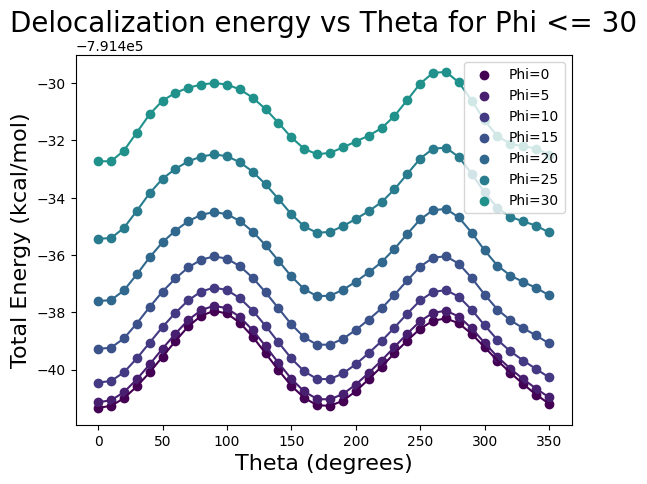

In [ ]:
for phi in phis:
    if phi <= 30:
        subset = sorted_deloc[sorted_deloc['Phi'] == phi]

        # Adjust this section accordingly based on implementation of E_conjugation in the deloc_energy calculation
        normed_energy = 627.509 * (subset['E_deloc'])  # Normalize energy
        normed_energy = normed_energy - 689  # Normalize energy
        energy = 627.509 * subset['E_deloc']

        # Map phi value to a color
        color = cmap(norm(phi))

        # Plot the normalized energy vs theta
        plt.plot(subset['Theta'], normed_energy, color=color)  # Replace 'E_total' with the actual column name for total energy
        plt.scatter(subset['Theta'], normed_energy, color=color, label=f"Phi={phi}")  # Replace 'E_total' with the actual column name for total energyy
plt.xlabel('Theta (degrees)', fontdict=axes)
plt.ylabel('Total Energy (kcal/mol)', fontdict=axes)
# plt.ylim(0,5)
plt.title(f'Delocalization energy vs Theta for Phi <= 30', fontdict=title)
plt.legend()
plt.show()

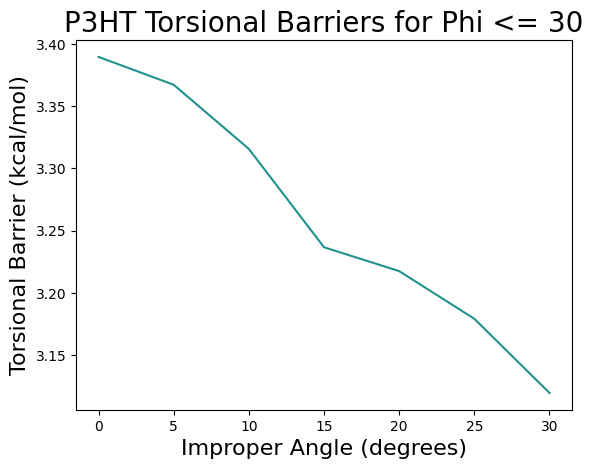

In [ ]:
def show_energy_barriers():
    barriers =[]
    phis_used=[]
    for phi in phis:
        if phi <= 30:
            subset = sorted_deloc[sorted_deloc['Phi'] == phi]
            e_conjugation = subset[subset['Theta'] == 0]['E_meth'].iloc[0]
            normed_energy = 627.509 * (subset['E_deloc'] - e_conjugation)  # Normalize energy
            normed_energy = normed_energy - 689  # Normalize energy
            max = np.max(normed_energy)
            min = np.min(normed_energy)
            phis_used.append(phi)
            barriers.append(max-min)
    plt.plot(phis_used, barriers, color=color) 
    plt.xlabel('Improper Angle (degrees)', fontdict=axes)
    plt.ylabel('Torsional Barrier (kcal/mol)', fontdict=axes)
    plt.title(f'P3HT Torsional Barriers for Phi <= 30', fontdict=title)
    plt.show()

show_energy_barriers()

In [ ]:
import pickle

with open('data.pkl', 'wb') as file:
    pickle.dump({'sorted_deloc': sorted_deloc, 'phis': phis}, file)